In [1]:
from datetime import datetime, timedelta
import pickle
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from tldextract import extract
import langid

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 50)

from newspaper import Article
import matplotlib.pyplot as plt

<ipython-input-1-cd00b3c2a068>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


NOTE: Mediacloud news for state-specific collection includes news ABOUT the particular state, and as such, might sometimes contain news from national outlets where the article itself might be focused on the state itself. Most (if not all) of the collection is going to be sourced from local state-specific outlets, but not always. Currently, we are keeping all URLs within the obtained collection for the state, except those from nytimes and foxnews since those are our chosen national outlets. Trusting mediacloud's collections to be truly state-focused even when urls come from national outlets. 

In [2]:
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-12-31', '%Y-%m-%d').date()

In [3]:
illinois_news = pd.read_csv('data/mediacloud_illinois.csv')
print(illinois_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   archived_url  2772 non-null   object
 1   article_url   2772 non-null   object
 2   id            2772 non-null   int64 
 3   language      2772 non-null   object
 4   media_name    2772 non-null   object
 5   media_url     2772 non-null   object
 6   publish_date  2772 non-null   object
 7   title         2772 non-null   object
 8   url           2772 non-null   object
dtypes: int64(1), object(8)
memory usage: 195.0+ KB
None


In [4]:
#analyze the distribution across months of publication -- are there gaps in the collection?
all_dates = list(illinois_news['publish_date'])
month_to_vol = {}
for i in range(1, 13):
    month_to_vol[i] = 0
for d in tqdm(all_dates):
    m = int(d.split('-')[1])
    month_to_vol[m] += 1

100%|██████████| 2772/2772 [00:00<00:00, 756349.90it/s]


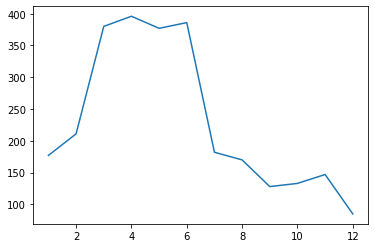

In [5]:
plt.plot(list(month_to_vol.keys()), list(month_to_vol.values()))

In [6]:
illinois_news[['language', 'media_name', 'media_url', 'publish_date', 'title', 'url']].tail(20)

,language,media_name,media_url,publish_date,title,url
2752,en,republictimes.net,http://republictimes.net,2023-03-29 00:00:00,Fallout from WHS restroom debateĀ – Republic-Times,https://www.republictimes.net/fallout-from-whs-restroom-debate/
2753,en,republictimes.net,http://republictimes.net,2023-06-28 00:00:00,Gender issue divides further - Republic-Times,https://www.republictimes.net/gender-issue-divides-further/
2754,en,republictimes.net,http://republictimes.net,2023-05-17 00:00:00,Gender policy closes school year,https://www.republictimes.net/gender-policy-closes-school-year/
2755,en,republictimes.net,http://republictimes.net,2023-07-19 00:00:00,Gender policy debate persists - Republic-Times,https://www.republictimes.net/gender-policy-debate-persists/
2756,en,republictimes.net,http://republictimes.net,2023-06-14 00:00:00,Gender policy still an issue - Republic-Times,https://www.republictimes.net/gender-policy-still-an-issue/
2757,en,republictimes.net,http://republictimes.net,2023-08-23 00:00:00,More concern with WHS bathroom policy,https://www.republictimes.net/more-concern-with-whs-bathroom-policy/
2758,en,republictimes.net,http://republictimes.net,2023-08-30 00:00:00,More from Waterloo School Board - Republic-Times,https://www.republictimes.net/more-from-waterloo-school-board/
2759,en,republictimes.net,http://republictimes.net,2023-10-18 00:00:00,More potty talk for Waterloo School Board,https://www.republictimes.net/more-potty-talk-for-the-school-board/
2760,en,republictimes.net,http://republictimes.net,2023-04-04 00:00:00,New mayor in Waterloo | Republic-Times,https://www.republictimes.net/new-mayor-in-waterloo/
2761,en,republictimes.net,http://republictimes.net,2023-04-19 00:00:00,New privacy policy at WHS – Republic-Times,https://www.republictimes.net/new-privacy-policy-at-whs/


In [7]:
relevant_news = illinois_news[~illinois_news['media_name'].isin(['foxnews.com',
                                                                 'nytimes.com'])]
relevant_news = relevant_news[relevant_news['language']=='en']
relevant_news = relevant_news[['media_name', 'publish_date', 'title', 'url']]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2769 entries, 0 to 2771
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   media_name    2769 non-null   object
 1   publish_date  2769 non-null   object
 2   title         2769 non-null   object
 3   url           2769 non-null   object
dtypes: object(4)
memory usage: 108.2+ KB
None


In [8]:
relevant_news.publish_date = pd.to_datetime(relevant_news.publish_date)
relevant_news = relevant_news[relevant_news['publish_date'].dt.date >= start_date]
relevant_news = relevant_news[relevant_news['publish_date'].dt.date <= end_date]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2769 entries, 0 to 2771
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    2769 non-null   object        
 1   publish_date  2769 non-null   datetime64[ns]
 2   title         2769 non-null   object        
 3   url           2769 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 108.2+ KB
None


In [9]:
def get_article_from_url(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        subtitle = article.meta_description
        if subtitle == '' or subtitle == ' ':
            subtitle = None
        text = article.text
        if text == '' or text == ' ':
            text = None
    except:
        subtitle = None
        text = None
    return subtitle, text

In [10]:
subtitles, texts = [], []
all_urls = list(relevant_news['url'])
for url in tqdm(all_urls):
    subtitle, text = get_article_from_url(url)
    subtitles.append(subtitle)
    texts.append(text)
relevant_news['subtitle'] = subtitles
relevant_news['text'] = texts
print(relevant_news.info())

100%|██████████| 2769/2769 [39:24<00:00,  1.17it/s] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2769 entries, 0 to 2771
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    2769 non-null   object        
 1   publish_date  2769 non-null   datetime64[ns]
 2   title         2769 non-null   object        
 3   url           2769 non-null   object        
 4   subtitle      1247 non-null   object        
 5   text          1359 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 151.4+ KB
None


In [11]:
relevant_news.to_csv('data/illinois_article_texts_and_info.csv',
                     index=False)